# Scraping the Jojo wiki for character networks
In this notebook we're gonna scrape the Jojo wiki to get a list of character names and build a network based on the story connections between those characters.

Procedure:
- Use the [character list](http://jojo.wikia.com/wiki/Category:Characters) to get character names, parts, and unique URLs.
- Go to each character page.
  - On each page, get the episodes or chapters in which the character appears.
- Inner join the list of appearances to find connections between characters who appear in the same episode.
- Use the list of connections to draw a network graph.

In [1]:
import requests
from bs4 import BeautifulSoup
from time import sleep
import pandas as pd
jojo_wiki_url = 'http://jojo.wikia.com'

In [2]:
## get the characters page
characters_url = jojo_wiki_url + '/wiki/Category:Characters'
sleep(2)
r = requests.get(characters_url)
characters_page = BeautifulSoup(r.content,'html.parser')

In [3]:
## find character names and hrefs
characters_df = pd.DataFrame()
tables = characters_page.find_all('table')
for table in tables:
    a = table.find_all('a')
    characters_links = [ah for ah in a if 'class' not in ah.attrs or ah.attrs['class'][0] == 'mw-redirect']
    characters = pd.DataFrame([{'href': c.attrs['href'], 'name':c.text} for c in characters_links])
    characters['part'] = tables.index(table) + 1
    characters_df = pd.concat([characters_df,characters])
characters_df.reset_index(inplace=True,drop=True)

## drop the names of the parts from the table
parts = ['Phantom Blood',
         'Battle Tendency',
         'Stardust Crusaders',
         'Diamond Is Unbreakable',
         'Vento Aureo',
         'Stone Ocean',
         'Steel Ball Run',
         'JoJolion']
characters_df.drop(characters_df[characters_df.name.isin(parts)].index, inplace=True)
characters_df.drop_duplicates(subset=['href','name'],keep='first',inplace=True)

In [5]:
def getCharLinks(h:str,manga=False):
    '''
    From a character page, get links to the anime episodes they appear in.
    
    Parameters
    ----------
    h : string. The character page URL.
    manga : boolean, default False. Controls whether appearances are scraped from anime episodes or manga chapters.
    '''
    media = 'Anime'
    if manga:
        media = 'Manga'
    sleep(2) # because we're being polite
    print('Getting appearances of {} ...'.format(jojo_wiki_url + h))
    r = requests.get(jojo_wiki_url + h)
    character_page = BeautifulSoup(r.content,'html.parser')
    # get the full table of chapter appearances
    heading = character_page.find('span',attrs={'id':'Chapters_.2F_Episodes'}).parent
    chapters = heading.next_sibling.next_sibling.find('th',text=' {} Appearances\n'.format(media)).parent.next_sibling.next_sibling.next_sibling.next_sibling.find_all('li')
    # get only the chapters they actually appear in
    chapters = [c for c in chapters if 'mentioned' not in c.text.lower() and
                                       'flashback' not in c.text.lower() and
                                       'photo' not in c.text.lower()]
    links = [c.a.attrs['href'] for c in chapters]
    return links

In [6]:
## make a dataframe with columns 'name' and 'appearance' just for characters in Part 1
characters_appearances = pd.DataFrame()
for i,row in characters_df.head(19).iterrows():
    links = pd.DataFrame(data=getCharLinks(row['href']),columns=['appearance'])
    links['name'] = row['name']
    characters_appearances = pd.concat([characters_appearances,links])
characters_appearances.reset_index(inplace=True,drop=True)

Getting appearances of http://jojo.wikia.com/wiki/Jonathan_Joestar ...
Getting appearances of http://jojo.wikia.com/wiki/William_Anthonio_Zeppeli ...
Getting appearances of http://jojo.wikia.com/wiki/Robert_E._O._Speedwagon ...
Getting appearances of http://jojo.wikia.com/wiki/Poco ...
Getting appearances of http://jojo.wikia.com/wiki/George_Joestar_I ...
Getting appearances of http://jojo.wikia.com/wiki/Tonpetty ...
Getting appearances of http://jojo.wikia.com/wiki/Straizo ...
Getting appearances of http://jojo.wikia.com/wiki/Dire ...
Getting appearances of http://jojo.wikia.com/wiki/Erina_Pendleton ...
Getting appearances of http://jojo.wikia.com/wiki/Danny ...
Getting appearances of http://jojo.wikia.com/wiki/Dio_Brando ...
Getting appearances of http://jojo.wikia.com/wiki/Wang_Chan ...
Getting appearances of http://jojo.wikia.com/wiki/Jack_the_Ripper ...
Getting appearances of http://jojo.wikia.com/wiki/Bruford ...
Getting appearances of http://jojo.wikia.com/wiki/Tarkus ...
Gettin

In [7]:
## merge the table to get connections
characters_connections = characters_appearances.merge(characters_appearances,on='appearance',how='inner')
## remove connections to oneself
characters_connections.drop(characters_connections[characters_connections['name_x'] == characters_connections['name_y']].index,inplace=True)
## remove obvious duplicate connections
characters_connections.drop_duplicates(subset=['name_x','name_y'],keep='first',inplace=True)

In [8]:
def sortNames(row:dict):
    '''
    Sorts a dictionary so that name_x is alphabetically prior to name_y.
    
    Parameters
    ----------
    row : dictionary. Must have keys 'name_x' and 'name_y'.
    '''
    x = row['name_x']
    y = row['name_y']
    if x > y:
        row['name_x'] = y
        row['name_y'] = x
    return {'name_x' : row['name_x'],
            'name_y' : row['name_y']}

In [9]:
## remove true duplicate connections
for i,row in characters_connections.iterrows():
    sorted_row = sortNames(row)
    row['name_x'] = sorted_row['name_x']
    row['name_y'] = sorted_row['name_y']
characters_connections.drop_duplicates(subset=['name_x','name_y'],keep='first',inplace=True)
characters_connections.reset_index(inplace=True,drop=True)

In [10]:
## make a simple network graph out of the connections
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

Text(1,1,'Part 1')

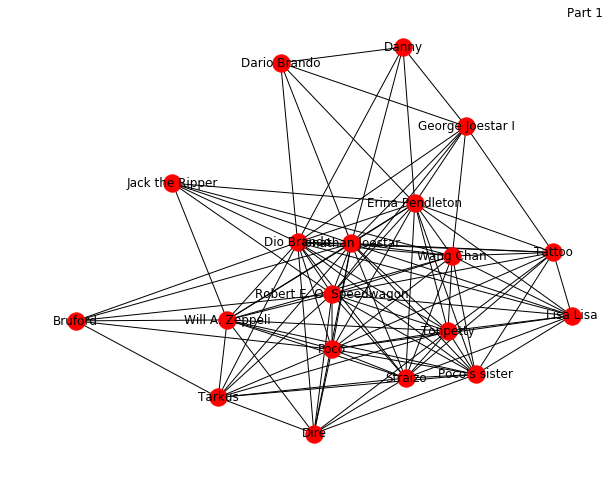

In [11]:
G = nx.from_pandas_edgelist(df=characters_connections,source='name_x',target='name_y',edge_attr='appearance')
fig,ax = plt.subplots(figsize=[10,8],)
nx.draw(G,with_labels=True,ax=ax)
ax.set_title('Part 1',loc='right')